### <ins>__Términos clave:__</ins>


* <ins>__Análisis de cohortes__</ins> se refiere a la práctica de agrupar usuarios basándose en características compartidas para un análisis en profundidad. En este caso, cada cohorte representa a los clientes agrupados por su año de registro.

* <ins>__La tasa de cancelación (churn rate)__</ins>  se calcula como el número de clientes que dejaron de realizar transacciones, dividido por el número total de clientes en ese mismo período de tiempo.

* <ins>__Se considera que un cliente ha cancelado (churned)__</ins> si ha tenido 100 días de inactividad de compra, basándose en la Fecha del Último Inicio de Sesión.

__Los clientes activos son aquellos que no han cancelado bajo esa definición.__

<ins>__Utilice el 31 de diciembre de 2022 como fecha de referencia para su análisis.__</ins>

La antigüedad de un cliente debe calcularse como el tiempo entre su primera y su última compra.

El período de <ins>__pre-compra__</ins> se define como el tiempo entre la fecha de registro del cliente y su primer pedido.

Los clientes que utilizaron crédito para reservas son aquellos con un Monto de Crédito (Credit Amount) diferente a 0.

### <ins>__Plan de acción:__</ins>

1. __Unificar y Limpiar Datos__: Juntaremos compras y devoluciones. Convertiremos las fechas y filtraremos todo según la fecha de referencia: 31 de diciembre de 2022.

2. __Crear Perfil por Cliente__: Agruparemos todos los datos por Member ID para tener una única fila por cliente con su información clave (primera/última compra, último login, etc.).

3. __Calcular las Nuevas Métricas__: Crearemos columnas extra:

__IsChurned__: Un indicador (Sí/No) basado en los 100 días de inactividad.

__CustomerTenure__: Antigüedad del cliente.

__PrePurchasePeriod__: Tiempo que tardó en hacer la primera compra.

__UsedCredit__: Un indicador (Sí/No) si usó crédito.

Para realizar y presentar el Análisis: vamos a calcular la tasa de cancelación general y la compararemos entre distintos segmentos (usuarios de crédito vs. no, cohortes de registro, etc.).

In [1]:
## Importamos librerías
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import os
import datetime
import missingno as msno 

In [5]:
# --- Carga y Preparación de Datos ---
# Cargar los archivos CSV en DataFrames
purchases_df = pd.read_csv("../Data/2025-07 purchases_challenge.csv")
refunds_df = pd.read_csv("../Data/2025-07 refunds_challenge.csv")

/var/folders/5w/lt_v_3kd3lnfmfqtkk8r9hjm0000gn/T/ipykernel_8609/228041537.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  purchases_df = pd.read_csv("../Data/2025-07 purchases_challenge.csv")


In [6]:
# Definimos la fecha de referencia para todo el análisis

REFERENCE_DATE = pd.to_datetime('2022-12-31')

In [7]:
## Hay que modificar las columnas "Signup Date", "Last Login Date", "First Order Date" y "Last Order Date"
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197639 entries, 0 to 197638
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Member ID         197639 non-null  int64  
 1   Signup Date       197639 non-null  object 
 2   Last Login Date   195622 non-null  object 
 3   Purchases         197639 non-null  int64  
 4   Total Amount      197639 non-null  float64
 5   Credit Amount     74379 non-null   float64
 6   First Order Date  197639 non-null  object 
 7   Last Order Date   197639 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 12.1+ MB


In [8]:
## Hay que modificar las columnas "Signup Date", "Last Login Date", "First Order Date" y "Last Order Date"
refunds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55467 entries, 0 to 55466
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Member ID         55467 non-null  int64  
 1   Signup Date       55467 non-null  object 
 2   Last Login Date   55268 non-null  object 
 3   Refunds           55467 non-null  int64  
 4   Total Amount      55467 non-null  float64
 5   Credit Amount     12485 non-null  float64
 6   First Order Date  55467 non-null  object 
 7   Last Order Date   55467 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 3.4+ MB


In [9]:
## convertimos todas las columnas de fecha, manejando errores
date_columns = ['Signup Date', 'Last Login Date', 'First Order Date', 'Last Order Date']
for col in date_columns:
    purchases_df[col] = pd.to_datetime(purchases_df[col], errors = 'coerce')
for col in date_columns:
    refunds_df[col] = pd.to_datetime(refunds_df[col], errors = 'coerce')

In [10]:
## Chequeo que se hayan modificado los tipos de datos de las columnas
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197639 entries, 0 to 197638
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Member ID         197639 non-null  int64         
 1   Signup Date       197639 non-null  datetime64[ns]
 2   Last Login Date   195622 non-null  datetime64[ns]
 3   Purchases         197639 non-null  int64         
 4   Total Amount      197639 non-null  float64       
 5   Credit Amount     74379 non-null   float64       
 6   First Order Date  197639 non-null  datetime64[ns]
 7   Last Order Date   197639 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(2)
memory usage: 12.1 MB


In [11]:
refunds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55467 entries, 0 to 55466
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Member ID         55467 non-null  int64         
 1   Signup Date       55467 non-null  datetime64[ns]
 2   Last Login Date   55268 non-null  datetime64[ns]
 3   Refunds           55467 non-null  int64         
 4   Total Amount      55467 non-null  float64       
 5   Credit Amount     12485 non-null  float64       
 6   First Order Date  55467 non-null  datetime64[ns]
 7   Last Order Date   55467 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(2)
memory usage: 3.4 MB


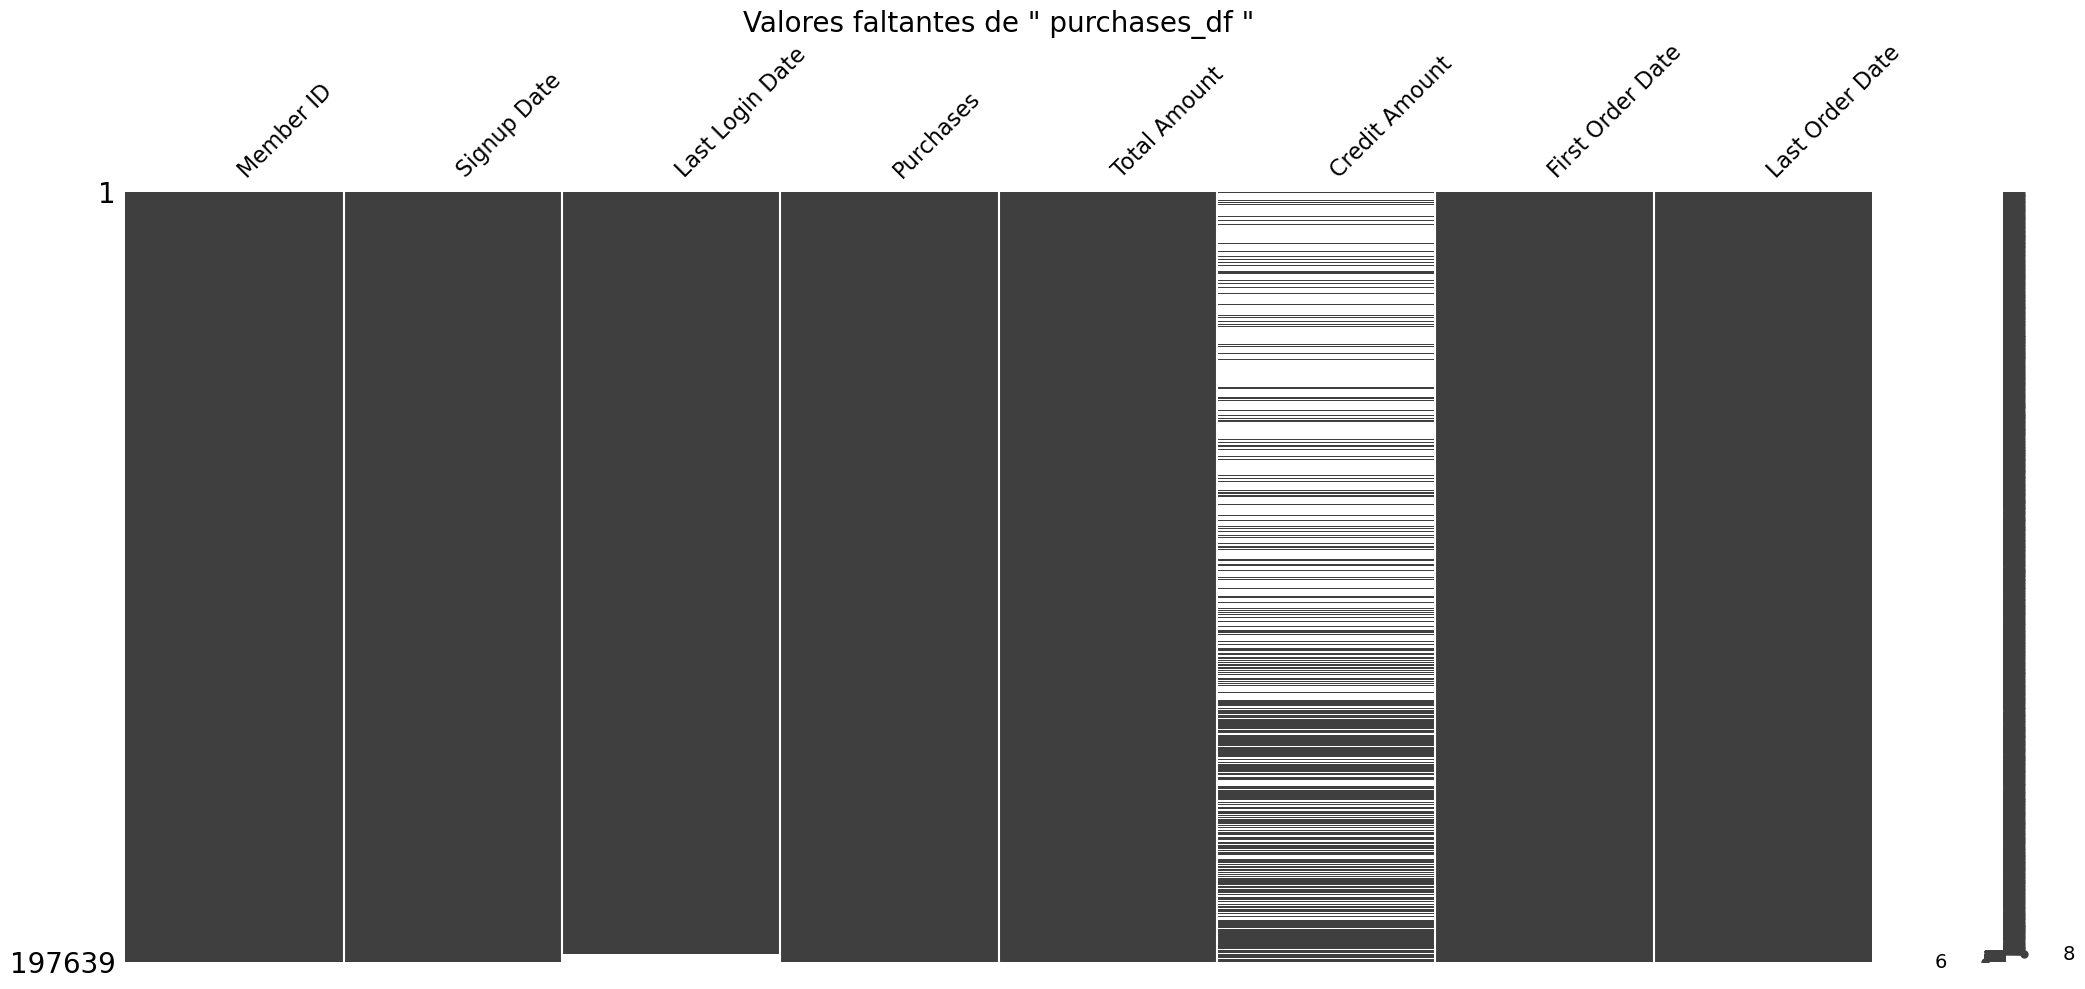

In [12]:
## Chequeo si hay valores faltantes en las columnas de ambos datasets
msno.matrix(purchases_df)
plt.title('Valores faltantes de " purchases_df "', fontsize = 20)
plt.show()

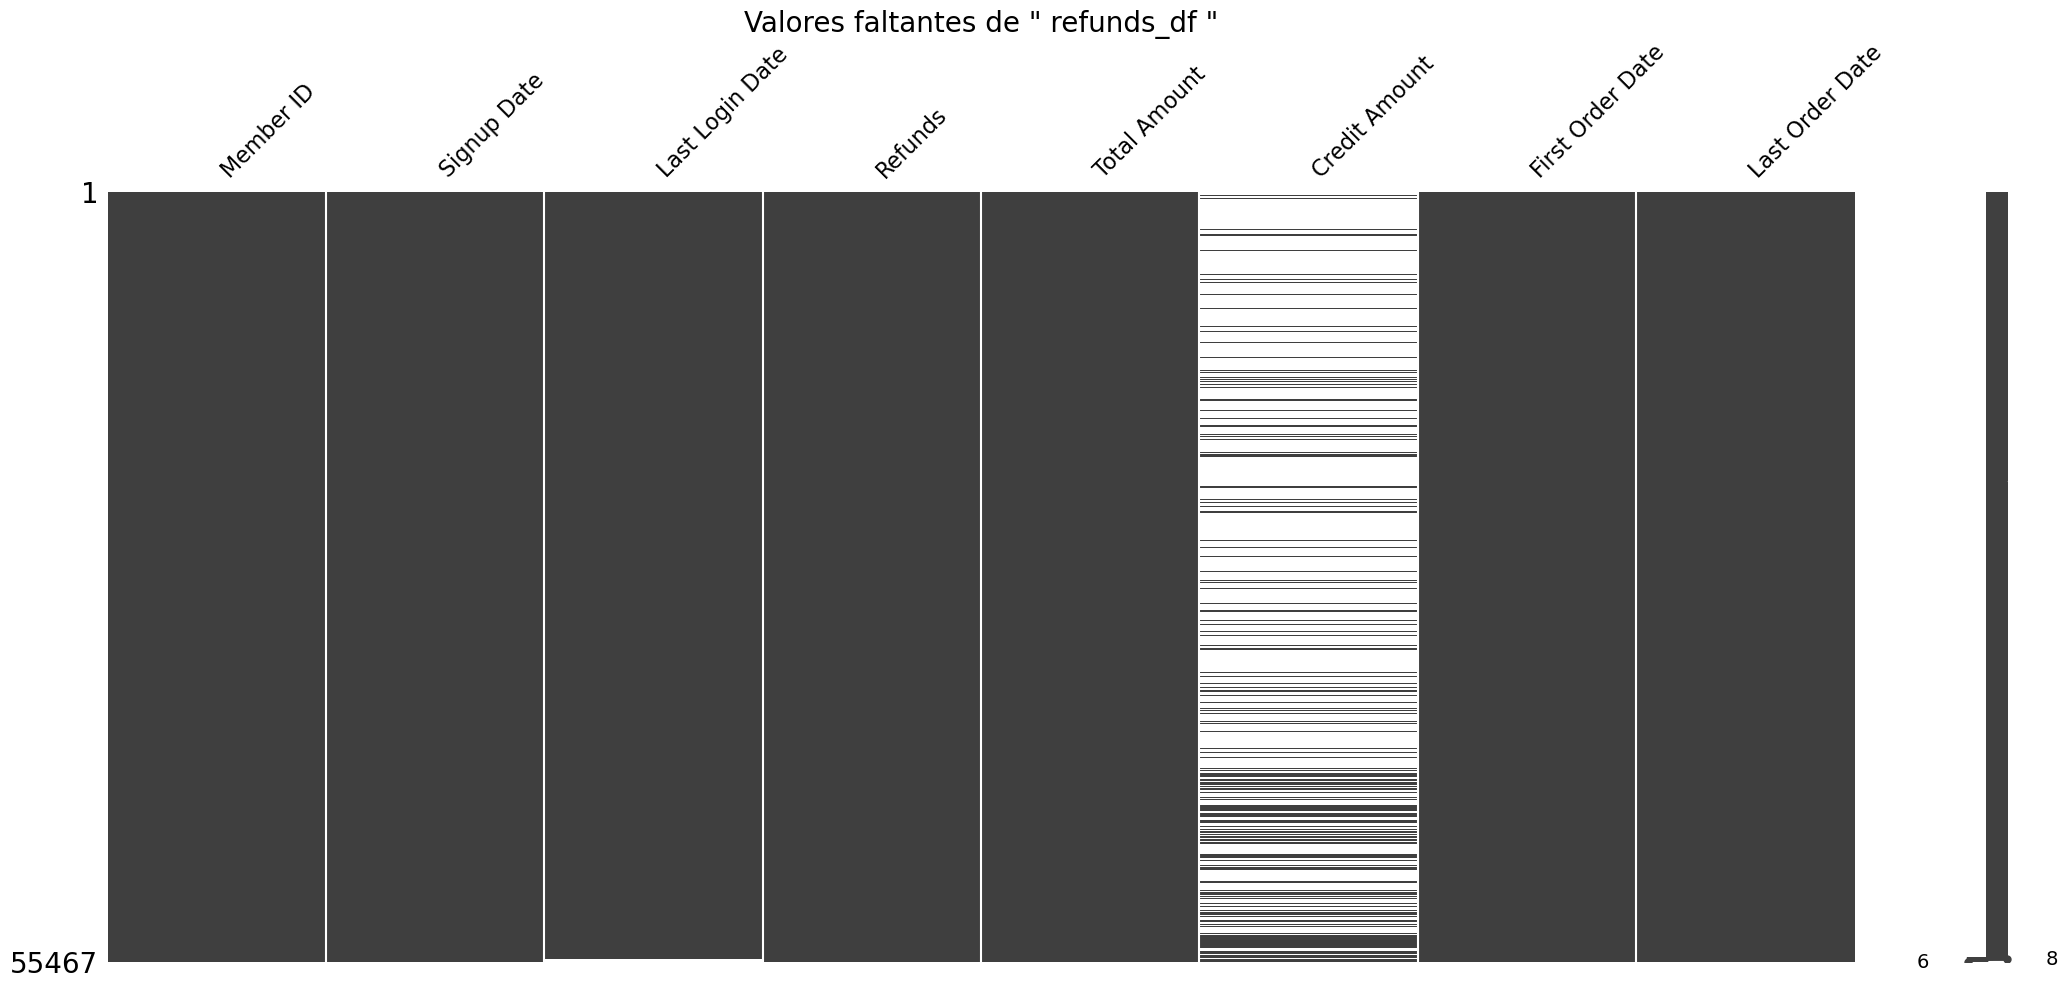

In [13]:
## Chequeo si hay valores faltantes en las columnas de ambos datasets
msno.matrix(refunds_df)
plt.title('Valores faltantes de " refunds_df "', fontsize = 20)
plt.show()

In [14]:
## Unimos todo en un solo dataframe 
## Usamos concat para tener un dataframe apilado arriba del otro, con el fin de mantener todos los detalles de todas las filas.

concatenado = pd.concat([purchases_df, refunds_df], ignore_index = True)

In [15]:
"Guardamos el dataframe creado"
#concatenado.to_csv('concatenado.csv', index=False)

'Guardamos el dataframe creado'

In [16]:
## Filtramos los datos para que todo sea anterior a la fecha de referencia
concatenado = concatenado[concatenado['Signup Date'] < REFERENCE_DATE]

In [17]:
## Eliminamos filas donde las fechas clave son nulas (ya sabemos de antemano que no hay valores faltantes en estas columnas)
concatenado.dropna(subset=['Signup Date', 'Last Login Date', 'First Order Date', 'Last Order Date'], inplace=True)

In [53]:
# --- Crear Perfil por Cliente (Agregación) ---

# Agrupamos por cliente para obtener una vista única
customer_df = concatenado.groupby('Member ID').agg(
        SignupDate=('Signup Date', 'first'),
        LastLoginDate=('Last Login Date', 'max'),
        FirstOrderDate=('First Order Date', 'min'),
        LastOrderDate=('Last Order Date', 'max'),
        TotalSpend=('Total Amount', 'sum'),
        # Ahora sumamos la columna 'Purchases' para obtener el conteo correcto de pedidos
        PurchaseOrders=('Purchases', 'sum'),
        CreditAmountSum=('Credit Amount', 'sum')
    ).reset_index()


    # Convertimos a entero
customer_df['PurchaseOrders'] = customer_df['PurchaseOrders'].astype(int)


In [54]:
customer_df

,Member ID,SignupDate,LastLoginDate,FirstOrderDate,LastOrderDate,TotalSpend,PurchaseOrders,CreditAmountSum
0,289584,2015-01-01,2021-01-22,2016-12-18,2016-12-18,401.51,1,0.0
1,289586,2015-01-01,2020-06-14,2020-01-30,2020-01-30,89.48,1,0.0
2,289592,2015-01-01,2023-05-01,2018-12-08,2018-12-08,128.03,1,0.0
3,289599,2015-01-01,2023-05-29,2019-01-29,2019-11-08,645.04,4,0.0
4,289616,2015-01-01,2023-05-10,2020-12-17,2023-03-27,2125.65,4,0.0
...,...,...,...,...,...,...,...,...
187934,1705017,2022-12-30,2023-06-01,2023-01-15,2023-05-27,1798.97,5,-35.0
187935,1705024,2022-12-30,2023-04-23,2023-03-18,2023-03-18,130.33,1,-10.0
187936,1705050,2022-12-30,2023-05-30,2023-01-23,2023-05-03,219.07,2,0.0
187937,1705086,2022-12-30,2023-05-31,2023-04-29,2023-04-29,965.08,1,0.0


In [76]:
## Unimos los conteos de pedidos al perfil del cliente>
#customer_df = customer_df.merge(purchase_orders, on='Member ID', how='left').fillna({'PurchaseOrders': 0})
#customer_df = customer_df.merge(refund_orders, on='Member ID', how='left').fillna({'RefundOrders': 0})

In [55]:
# --- Calcular las Nuevas Métricas ---

# 1. Indicador de Cancelación (Churn)
days_since_last_login = (REFERENCE_DATE - customer_df['LastLoginDate']).dt.days
customer_df['IsChurned'] = days_since_last_login > 100

# 2. Antigüedad del Cliente (Tenure)
customer_df['CustomerTenureDays'] = (customer_df['LastOrderDate'] - customer_df['FirstOrderDate']).dt.days
    
# Filtramos antigüedades negativas por si hay errores de datos
customer_df = customer_df[customer_df['CustomerTenureDays'] >= 0]
    
# 3. Período de Pre-Compra
customer_df['PrePurchasePeriodDays'] = (customer_df['FirstOrderDate'] - customer_df['SignupDate']).dt.days
customer_df = customer_df[customer_df['PrePurchasePeriodDays'] >= 0]
    
# 4. Uso de Crédito
customer_df['UsedCredit'] = customer_df['CreditAmountSum'].notna() & (customer_df['CreditAmountSum'] != 0)

In [56]:
# --- Realizar y Presentar el Análisis ---
    
print(f"--- 📊 Análisis de Cancelación (Churn) al {REFERENCE_DATE.date()} ---")

# Tasa de cancelación general

total_customers = len(customer_df) ## Se calcula el total de clientes
churned_customers = customer_df['IsChurned'].sum()
churn_rate_total = (churned_customers / total_customers) * 100
print(f"\n1. Tasa de Cancelación General: {churn_rate_total:.2f}% ({churned_customers} de {total_customers} clientes)")

--- 📊 Análisis de Cancelación (Churn) al 2022-12-31 ---

1. Tasa de Cancelación General: 38.16% (71723 de 187939 clientes)


In [57]:
# Análisis por uso de crédito
print(f"--- 📊 Análisis de Cancelación (Churn) al {REFERENCE_DATE.date()} ---")
churn_by_credit = customer_df.groupby('UsedCredit')['IsChurned'].mean() * 100
print("\n2. Tasa de Cancelación por Uso de Crédito:")
print(f"   - Clientes que USARON crédito: {churn_by_credit[True]:.2f}%")
print(f"   - Clientes que NO usaron crédito: {churn_by_credit[False]:.2f}%")    

--- 📊 Análisis de Cancelación (Churn) al 2022-12-31 ---

2. Tasa de Cancelación por Uso de Crédito:
   - Clientes que USARON crédito: 22.19%
   - Clientes que NO usaron crédito: 46.91%


In [58]:
print(f"--- 📊 Análisis de Cancelación (Churn) al {REFERENCE_DATE.date()} ---")
# Análisis de características de clientes cancelados vs. activos
print("\n3. Comparación entre Clientes Activos y Cancelados (Promedios):")
comparison = customer_df.groupby('IsChurned')[['CustomerTenureDays', 'PrePurchasePeriodDays', 'TotalSpend']].mean()
print(comparison.round(2))


--- 📊 Análisis de Cancelación (Churn) al 2022-12-31 ---

3. Comparación entre Clientes Activos y Cancelados (Promedios):
           CustomerTenureDays  PrePurchasePeriodDays  TotalSpend
IsChurned                                                       
False                  588.66                 436.37     1614.07
True                   222.36                 292.26      697.81


In [59]:
print(f"--- 📊 Análisis de Cancelación (Churn) al {REFERENCE_DATE.date()} ---")
# Análisis de churn por año de registro
customer_df['SignupYear'] = customer_df['SignupDate'].dt.year
churn_by_signup_year = customer_df.groupby('SignupYear')['IsChurned'].mean() * 100
print("\n4. Tasa de Cancelación por Año de Registro (Cohorte):")
print(churn_by_signup_year.round(2).to_string())

--- 📊 Análisis de Cancelación (Churn) al 2022-12-31 ---

4. Tasa de Cancelación por Año de Registro (Cohorte):
SignupYear
2015    44.34
2016    44.38
2017    46.67
2018    43.68
2019    41.87
2020    42.45
2021    37.31
2022    13.67


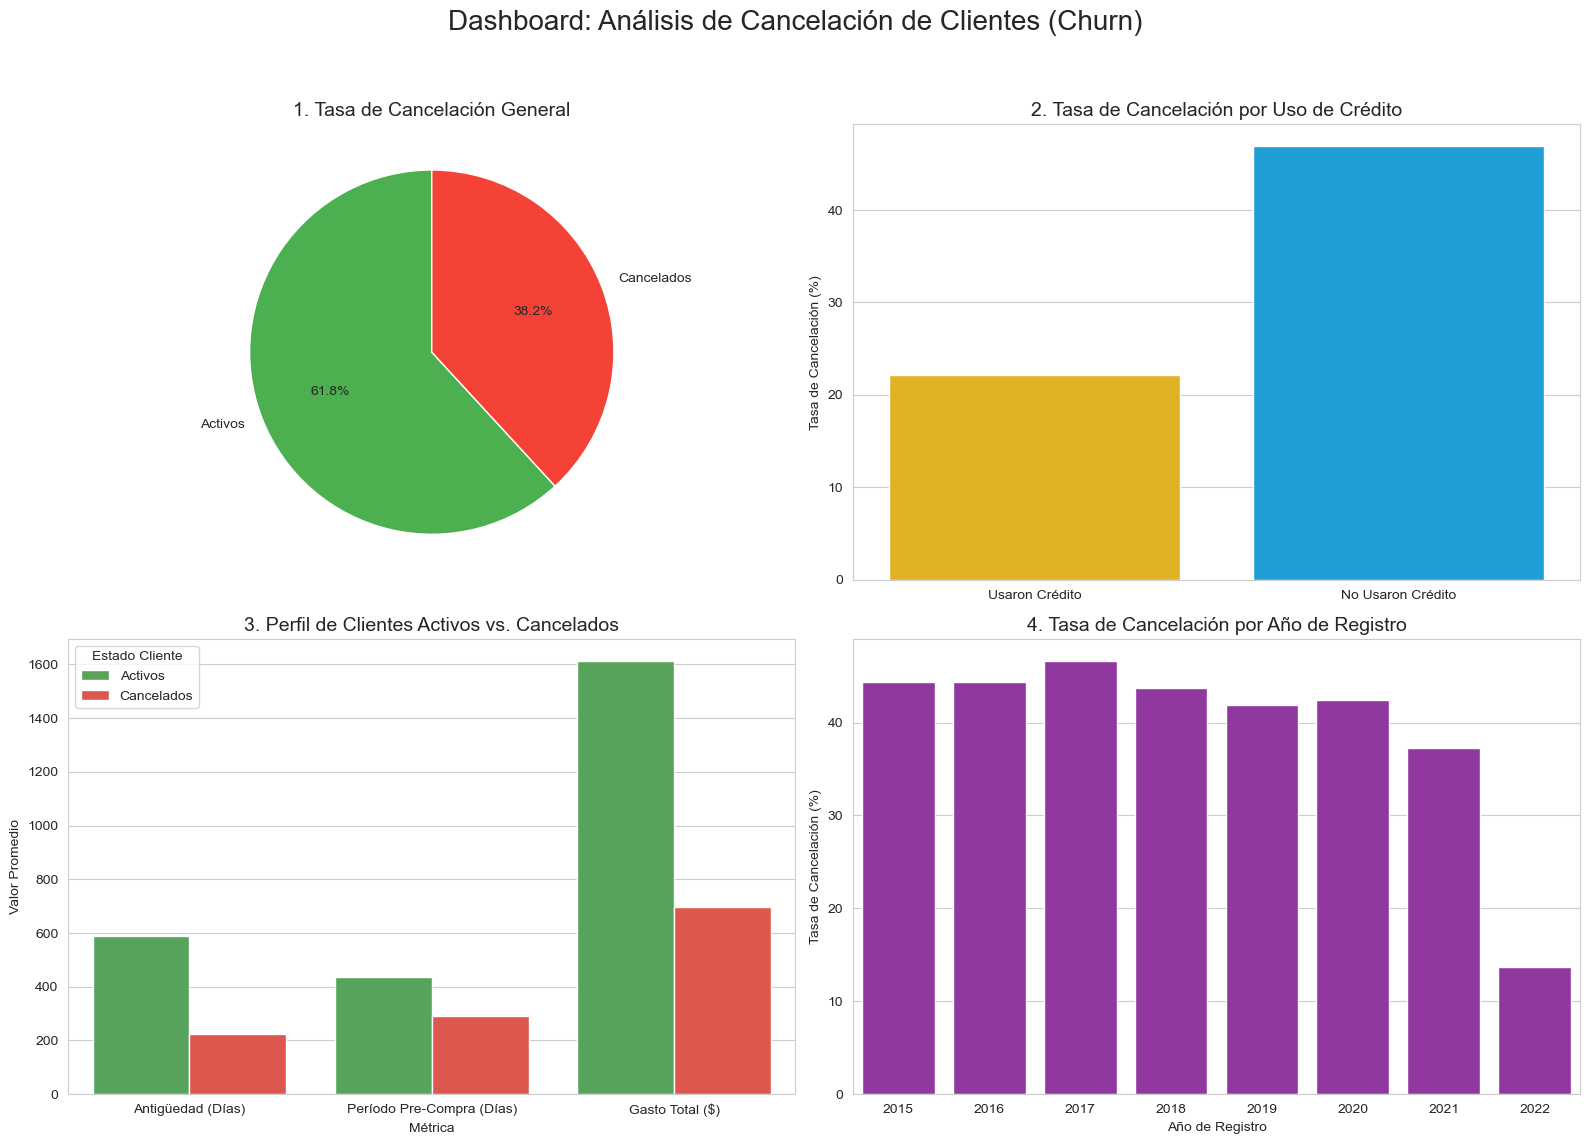

In [60]:
# --- Preparamos los datos del resumen para graficar ---

# 1. Datos para Tasa de Cancelación General
churn_general_data = {
    'Categoría': ['Activos', 'Cancelados'],
    'Porcentaje': [100 - 38.16, 38.16]
}
# 2. Datos para Tasa de Cancelación por Uso de Crédito
churn_credit_data = {
    'Categoría': ['Usaron Crédito', 'No Usaron Crédito'],
    'Tasa de Cancelación (%)': [22.19, 46.91]
}
df_churn_credit = pd.DataFrame(churn_credit_data)
# 3. Datos para Comparación de Clientes
comparison_data = {
    'Métrica': ['Antigüedad (Días)', 'Período Pre-Compra (Días)', 'Gasto Total ($)'],
    'Activos': [588.66, 436.37, 1614.07],
    'Cancelados': [222.36, 292.26, 697.81]
}
df_comparison = pd.melt(pd.DataFrame(comparison_data), id_vars=['Métrica'], var_name='Estado Cliente', value_name='Valor')
# 4. Datos para Tasa de Cancelación por Año
churn_year_data = {
    'Año de Registro': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'Tasa de Cancelación (%)': [44.34, 44.38, 46.67, 43.68, 41.87, 42.45, 37.31, 13.67]
}
df_churn_year = pd.DataFrame(churn_year_data)

# --- Generamos los 4 Gráficos ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard: Análisis de Cancelación de Clientes (Churn)', fontsize=20)

# Gráfico 1: Tasa de Cancelación General
axes[0, 0].pie(churn_general_data['Porcentaje'], labels=churn_general_data['Categoría'], autopct='%1.1f%%',
               startangle=90, colors=['#4CAF50', '#F44336'])
axes[0, 0].set_title('1. Tasa de Cancelación General', fontsize=14)

# Gráfico 2: Tasa de Cancelación por Uso de Crédito
sns.barplot(
    ax=axes[0, 1], 
    x='Categoría', 
    y='Tasa de Cancelación (%)', 
    data=df_churn_credit, 
    palette=['#FFC107', '#03A9F4'],
    hue='Categoría',  # Añadimos 'hue'
    legend=False      # Ocultamos la leyenda que se genera automáticamente
)
axes[0, 1].set_title('2. Tasa de Cancelación por Uso de Crédito', fontsize=14)
axes[0, 1].set_ylabel('Tasa de Cancelación (%)')
axes[0, 1].set_xlabel('')

# Gráfico 3: Comparación entre Clientes Activos y Cancelados
sns.barplot(ax=axes[1, 0], x='Métrica', y='Valor', hue='Estado Cliente', data=df_comparison, palette=['#4CAF50', '#F44336'])
axes[1, 0].set_title('3. Perfil de Clientes Activos vs. Cancelados', fontsize=14)
axes[1, 0].set_xlabel('Métrica')
axes[1, 0].set_ylabel('Valor Promedio')

# Gráfico 4: Tasa de Cancelación por Año de Registro
sns.barplot(ax=axes[1, 1], x='Año de Registro', y='Tasa de Cancelación (%)', data=df_churn_year, color='#9C27B0')
axes[1, 1].set_title('4. Tasa de Cancelación por Año de Registro', fontsize=14)
axes[1, 1].set_ylabel('Tasa de Cancelación (%)')
axes[1, 1].set_xlabel('Año de Registro')

# Ajustamos y mostramos el dashboard
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [61]:
## Este es el dataframe creado con las nuevas columnas adicionales y agrupado por Member ID
#customer_df.to_csv('customer_df.csv', index=False)
#customer_df.head()

,Member ID,SignupDate,LastLoginDate,FirstOrderDate,LastOrderDate,TotalSpend,PurchaseOrders,CreditAmountSum,IsChurned,CustomerTenureDays,PrePurchasePeriodDays,UsedCredit,SignupYear
0,289584,2015-01-01,2021-01-22,2016-12-18,2016-12-18,401.51,1,0.0,True,0,717,False,2015
1,289586,2015-01-01,2020-06-14,2020-01-30,2020-01-30,89.48,1,0.0,True,0,1855,False,2015
2,289592,2015-01-01,2023-05-01,2018-12-08,2018-12-08,128.03,1,0.0,False,0,1437,False,2015
3,289599,2015-01-01,2023-05-29,2019-01-29,2019-11-08,645.04,4,0.0,False,283,1489,False,2015
4,289616,2015-01-01,2023-05-10,2020-12-17,2023-03-27,2125.65,4,0.0,False,830,2177,False,2015


### --- Cálculo y Presentación de las 10 Métricas Solicitadas ---

In [62]:
print(f"--- 📋 Métricas Clave al {REFERENCE_DATE.date()} ---")

    # 1. Período mínimo de pre-compra
min_prepurchase = customer_df['PrePurchasePeriodDays'].min()
print(f"\n1. Período MÍNIMO de pre-compra: {min_prepurchase} días")

--- 📋 Métricas Clave al 2022-12-31 ---

1. Período MÍNIMO de pre-compra: 0 días


In [63]:
    # 2. Período máximo de pre-compra
max_prepurchase = customer_df['PrePurchasePeriodDays'].max()
print(f"2. Período MÁXIMO de pre-compra: {max_prepurchase} días")

2. Período MÁXIMO de pre-compra: 3059 días


In [64]:
# Agrupamos por estado de churn para las siguientes métricas
grouped_by_churn = customer_df.groupby('IsChurned')

In [65]:
    # 3. Antigüedad promedio de los clientes activos
avg_tenure_active = grouped_by_churn['CustomerTenureDays'].mean()[False]
print(f"\n3. Antigüedad promedio de clientes ACTIVOS: {avg_tenure_active:.2f} días")


3. Antigüedad promedio de clientes ACTIVOS: 588.66 días


In [66]:
    # 4. Antigüedad promedio de los clientes cancelados
avg_tenure_churned = grouped_by_churn['CustomerTenureDays'].mean()[True]
print(f"4. Antigüedad promedio de clientes CANCELADOS: {avg_tenure_churned:.2f} días")

4. Antigüedad promedio de clientes CANCELADOS: 222.36 días


In [67]:
purchase_orders = concatenado[concatenado['Total Amount'] > 0].groupby('Member ID').size().rename('PurchaseOrders')
customer_df['PurchaseOrders'] = customer_df['PurchaseOrders'].astype(int)

In [68]:
    # 5. Número promedio de pedidos realizados por clientes cancelados
avg_orders_churned = grouped_by_churn['PurchaseOrders'].mean()[True]
print(f"\n5. Número promedio de pedidos de clientes CANCELADOS: {avg_orders_churned:.2f}")


5. Número promedio de pedidos de clientes CANCELADOS: 3.02


In [69]:
    # 6. Número promedio de pedidos realizados por clientes activos
avg_orders_active = grouped_by_churn['PurchaseOrders'].mean()[False]
print(f"6. Número promedio de pedidos de clientes ACTIVOS: {avg_orders_active:.2f}")


6. Número promedio de pedidos de clientes ACTIVOS: 6.02


In [70]:
    # 7. Monto promedio gastado por clientes cancelados
avg_spend_churned = grouped_by_churn['TotalSpend'].mean()[True]
print(f"\n7. Gasto neto promedio de clientes CANCELADOS: ${avg_spend_churned:.2f}")



7. Gasto neto promedio de clientes CANCELADOS: $697.81


In [71]:
    # 8. Monto promedio gastado por clientes activos
avg_spend_active = grouped_by_churn['TotalSpend'].mean()[False]
print(f"8. Gasto neto promedio de clientes ACTIVOS: ${avg_spend_active:.2f}")


8. Gasto neto promedio de clientes ACTIVOS: $1614.07


In [72]:
    # 9. Tasa de reembolso basada en el número de pedidos
total_purchase_orders = concatenado[concatenado['Total Amount'] > 0].shape[0]
total_refund_orders = concatenado[concatenado['Total Amount'] < 0].shape[0]
refund_rate_by_orders = (total_refund_orders / total_purchase_orders) * 100
print(f"\n9. Tasa de reembolso por NÚMERO de pedidos: {refund_rate_by_orders:.2f}%")


9. Tasa de reembolso por NÚMERO de pedidos: 28.41%


In [73]:
        # 10. Tasa de reembolso basada en el monto gastado
total_purchase_amount = concatenado[concatenado['Total Amount'] > 0]['Total Amount'].sum()
total_refund_amount = abs(concatenado[concatenado['Total Amount'] < 0]['Total Amount'].sum())
refund_rate_by_amount = (total_refund_amount / total_purchase_amount) * 100
print(f"10. Tasa de reembolso por MONTO gastado: {refund_rate_by_amount:.2f}%")

10. Tasa de reembolso por MONTO gastado: 18.13%


### Averiguando un poco más:

In [77]:

# Calcular el período de pre-compra en días
customer_df['PrePurchasePeriodDays'] = (customer_df['FirstOrderDate'] - customer_df['SignupDate']).dt.days

# Filtrar resultados ilógicos
customer_df = customer_df[customer_df['PrePurchasePeriodDays'] >= 0]

# Calcular las tres estadísticas
promedio = customer_df['PrePurchasePeriodDays'].mean()
mediana = customer_df['PrePurchasePeriodDays'].median()
moda = customer_df['PrePurchasePeriodDays'].mode()[0]  # .mode() puede devolver varios valores, tomamos el primero

print("--- 📊 Estadísticas del Período de Pre-Compra ---")
print(f"Promedio: {promedio:.2f} días")
print(f"Mediana: {mediana:.0f} días")
print(f"Moda (valor más común): {moda:.0f} días")

--- 📊 Estadísticas del Período de Pre-Compra ---
Promedio: 381.37 días
Mediana: 151 días
Moda (valor más común): 1 días


### __Qué Muestra el Gráfico?__

El histograma (las barras) te mostrará que una gran cantidad de clientes compra en los primeros días después de registrarse.

Las líneas verticales te permitirán ver visualmente dónde se ubican tus estadísticas clave. Notarás que la línea del promedio (roja) probablemente esté más a la derecha que la mediana (verde), porque el promedio es "arrastrado" por esos pocos clientes que tardan mucho tiempo en hacer su primera compra.
"""

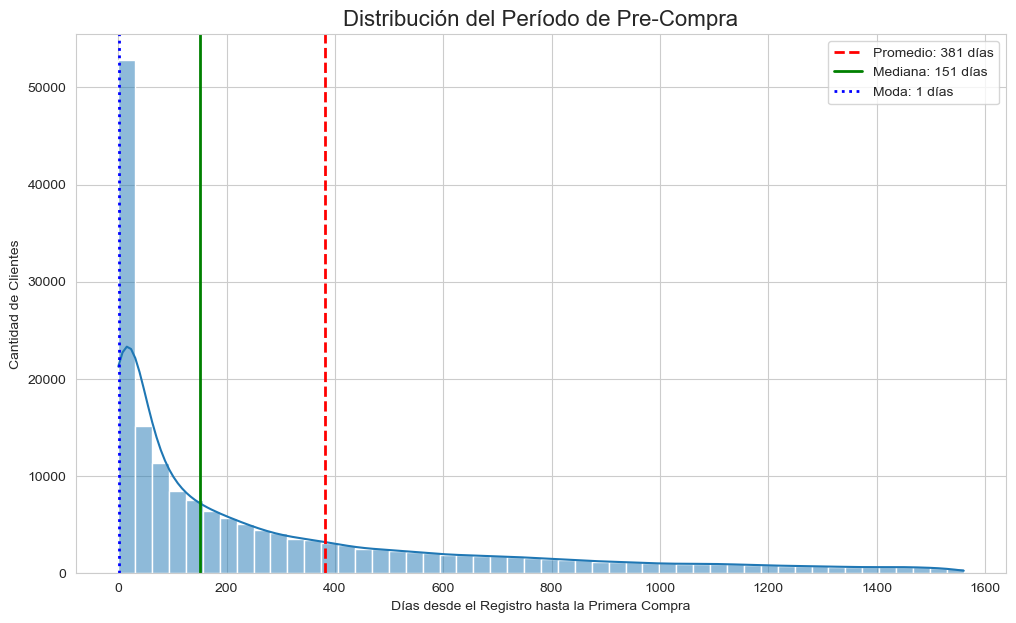

In [78]:

# --- Creación del Gráfico ---
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Crear el histograma
# Filtramos para una mejor visualización, excluyendo valores muy extremos si los hubiera
sns.histplot(data=customer_df[customer_df['PrePurchasePeriodDays'] < customer_df['PrePurchasePeriodDays'].quantile(0.95)], 
             x='PrePurchasePeriodDays', 
             bins=50, 
             kde=True)

# Añadir las líneas verticales para las estadísticas
plt.axvline(promedio, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedio:.0f} días')
plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.0f} días')
plt.axvline(moda, color='blue', linestyle=':', linewidth=2, label=f'Moda: {moda:.0f} días')

# Títulos y leyenda
plt.title('Distribución del Período de Pre-Compra', fontsize=16)
plt.xlabel('Días desde el Registro hasta la Primera Compra')
plt.ylabel('Cantidad de Clientes')
plt.legend()
plt.show()

## Análisis Detallado

La Moda (1 día) es la Historia de Éxito: El pico masivo del gráfico al principio (la moda) indica que el comportamiento más común es que un cliente se registre y compre casi de inmediato (en 1 día). Esto es excelente y sugiere que tienes un gran grupo de usuarios con alta intención de compra que llegan a la plataforma listos para reservar.

La Mediana (151 días) revela la Gran Oportunidad: Este es el dato clave. La mediana nos dice que el 50% de tus clientes tarda hasta 5 meses en hacer su primera compra. Esto dibuja un segundo perfil de cliente: el "planificador" o el "curioso". Se registran, pero no tienen una necesidad inmediata y esperan el momento o la oferta adecuada.

El Promedio (381 días) está Sesgado: El promedio es mucho más alto que la mediana. Esto confirma que la distribución está fuertemente sesgada a la derecha, lo que significa que unos pocos clientes que tardan muchísimo tiempo en comprar (outliers) están "inflando" el promedio. Para entender al cliente típico, la mediana (151 días) es una métrica mucho más confiable que el promedio.

## Conclusiones Estratégicas

El gráfico te dice que no tienes un tipo de cliente, sino dos muy diferentes a los que puedes dirigirte con estrategias distintas:

Para los Compradores Inmediatos (la Moda): El proceso desde que descubren una oferta hasta que finalizan la reserva debe ser impecable, rápido y sin fricción. Cualquier obstáculo puede hacer que pierdas estas conversiones de alto valor.

Para los Planificadores (la Mediana y la cola larga): Aquí está la mayor área de oportunidad para ID90. Si logras reducir la mediana de 151 días, acelerarás tus ingresos de manera significativa.

Acción Recomendada: Implementar una campaña de onboarding por correo electrónico. Cuando un usuario se registra y no compra en los primeros 7-15 días, se le puede enviar una secuencia de correos para:

Mostrarle cómo sacar el máximo provecho a la plataforma.

Presentarle ofertas personalizadas basadas en su aerolínea o ubicación.

Crear un sentido de urgencia con ofertas por tiempo limitado.